# Open carbonate system

The solution is in equilibrium with the atmospheric partial pressure of CO2

To model everything phreeqpython was used a python wrapper for phreeqc

In [44]:
from phreeqpython import PhreeqPython

import numpy as np


from matplotlib import pyplot as plt

import pandas as  pd


In [45]:
# some unecessary style settings

plt.rcParams.update({'font.size': 22,
                     #font.weight':'bold',
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'lines.linewidth' :  4,
                     'axes.labelsize'  : 20.0,
                     'axes.titlesize':  20,
                     'figure.titlesize': 'x-large',
                     'legend.fontsize': 18.0,})



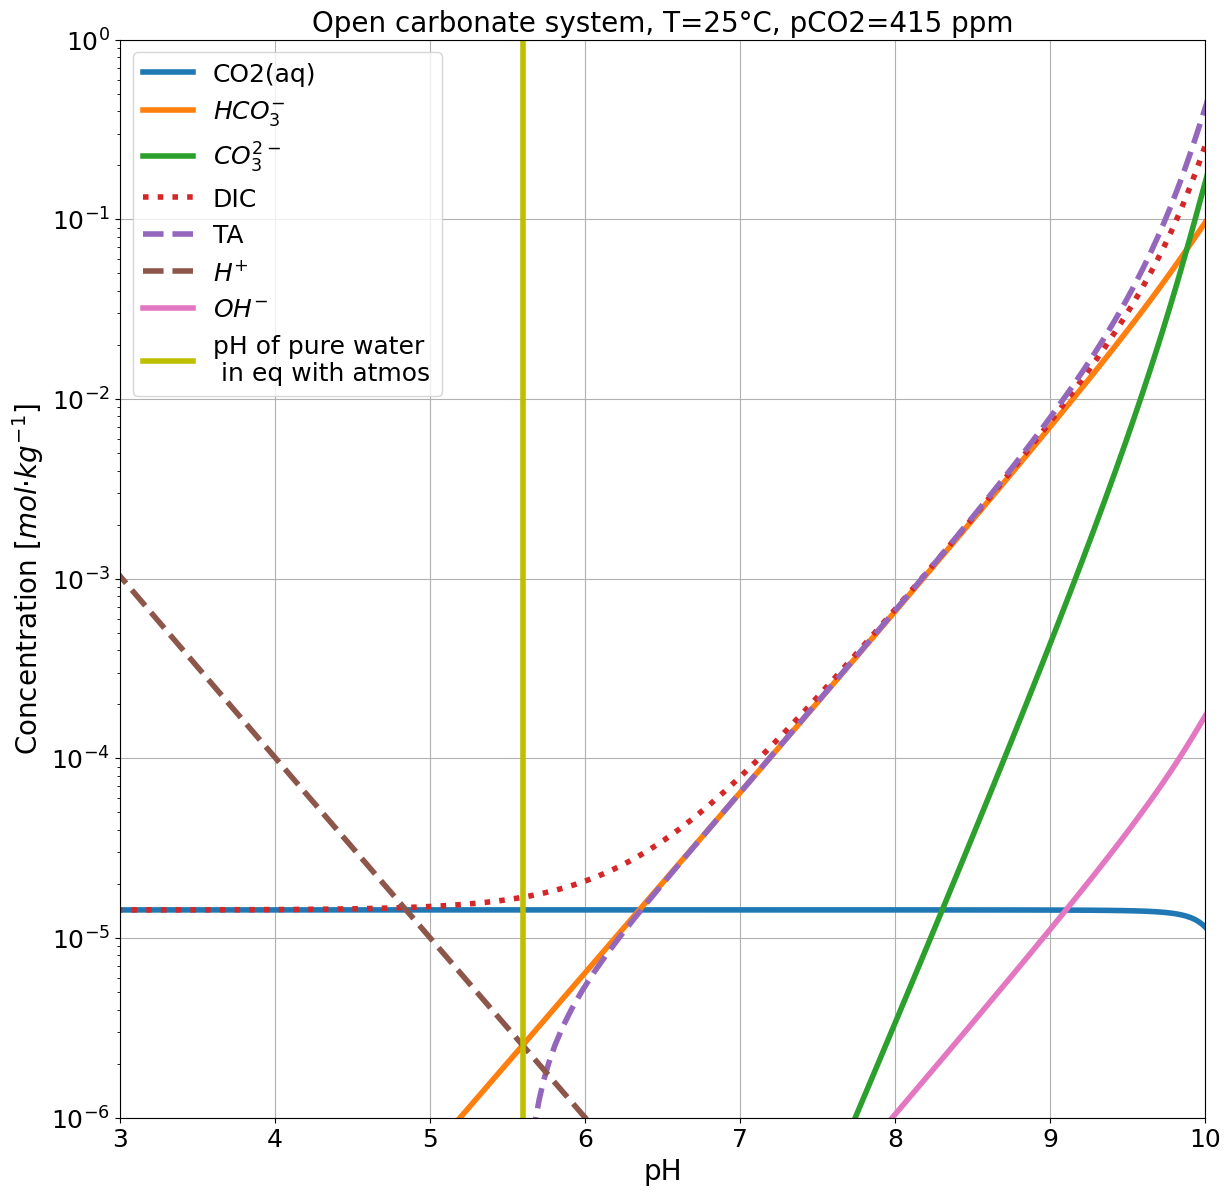

In [46]:
# use the vitens database for all constants

# create new PhreeqPython instance
pp = PhreeqPython(database='vitens.dat')

#for differnt NaOH doses

c=np.arange(1,10.1,0.1)




pH_full=np.arange(2,14.5,0.1)


#create a dataframe to save the results
col_names=['pH','DIC']

#fractions
df=pd.DataFrame(data=np.zeros([pH_full.size,len(col_names)]),columns=col_names)
df['pH']=pH_full







# empty list that will be filled
DIC, pH_value, CO2, HCO3, CO3, TA, OH, H   =[], [], [], [], [], [], [], []

temp=25

# in Phreeqc default units are mmol/kgw
solution1=pp.add_solution({'temp':temp})

#concentration CO2
p=415 # ppm

#partial pressure pCO2 in atm
pCO2=p*1e-6 


for item in pH_full:

    
    #make a copy of the inital solution for the calculation
    # this prevents overwriting the solution and always starts new from scratch
    # always new fresh water
    sol = solution1.copy()
    
    
    #change the pH with HCl or NaOH
    sol.change_ph(item)
    
    #phreeqc always uses log10 values
    input_pCO2=np.log10(pCO2)
    
    
    # equalize solution with CO2
    # equilibrium with atmosphere
    sol.equalize(['CO2(g)'], [input_pCO2])
       
    #make sure  the unit is mol
    #co2=sol.total('CO2',units='mol')
    #hco3=sol.total('HCO3',units='mol')
    #co3=sol.total('CO3',units='mol')
    
    
    #test with species
    co2=sol.species['CO2'] #mol/kg
    hco3=sol.species['HCO3-'] #mol/kg
    co3=sol.species['CO3-2'] #mol/kg
    
    
    rho=sol.mass
    
    # get the H and OH concentrations
    h=sol.species['H+']   # species are in mol/l
    oh=sol.species['OH-'] 
    
    # simple 
    dic=co2+hco3+co3
    
    #alkalinity definition of the pure carbonate system (no other species than carbonates, OH-, H+, HCO3-, CO3-2 involved )
    ta=hco3+2*co3+oh-h


    #write data into lists for plots later
    DIC.append(dic)
    CO2.append(co2)
    HCO3.append(hco3)
    CO3.append(co3)
    pH_value.append(sol.pH)
    TA.append(ta)
    OH.append(oh)
    H.append(h)


# quick calculation of the zero TA
# the zero alkalinity pH (just pure water + atmosphere)

T=25

solution_zero=pp.add_solution({'temp':T})
solution_zero.equalize(['CO2(g)'], [input_pCO2])
zero_pH=solution_zero.pH
zero_DIC=solution_zero.total('CO2',units='mol')+solution_zero.total('HCO3',units='mol')+solution_zero.total('CO3',units='mol')




fig = plt.figure(figsize=[14,14])
plt.plot(pH_value,CO2,label='CO2(aq)')
plt.plot(pH_value,HCO3,label='$HCO_{3}^{-}$')
plt.plot(pH_value,CO3,label='$CO_{3}^{2-}$')
plt.plot(pH_value,DIC,label='DIC',linestyle='dotted')
plt.plot(pH_value,TA,label='TA',linestyle='dashed')
plt.plot(pH_value,H,label='$H^{+}$',linestyle='dashed')
plt.plot(pH_value,OH,label='$OH^{-}$')


# line for TA=0
plt.axvline(x=zero_pH, color = 'y', label = 'pH of pure water \n in eq with atmos')

plt.xlabel("pH")
plt.ylabel("Concentration [$mol·kg^{−1}$]")

plt.yscale('log')

ax = plt.gca()
ax.grid(True)

plt.xlim([3,10])
plt.ylim([1e-6,1e0])
plt.title('Open carbonate system, T={}°C, pCO2={} ppm'.format(temp,p))
plt.legend()



plt.savefig('open-carbonate-system-plot.pdf')  

plt.show()

#combine to pandas dartaframe to check the results

d = {'pH':pH_value,'HCO3-':HCO3,'OH-':OH,'H+':H,'CO3-2':CO3,'DIC':DIC}

df=pd.DataFrame(d)

#safe the data into csv
df.to_csv('open_carbonate_system_phreeqpython.csv', index=False, encoding='utf-8')




# make a DIC(pH) plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


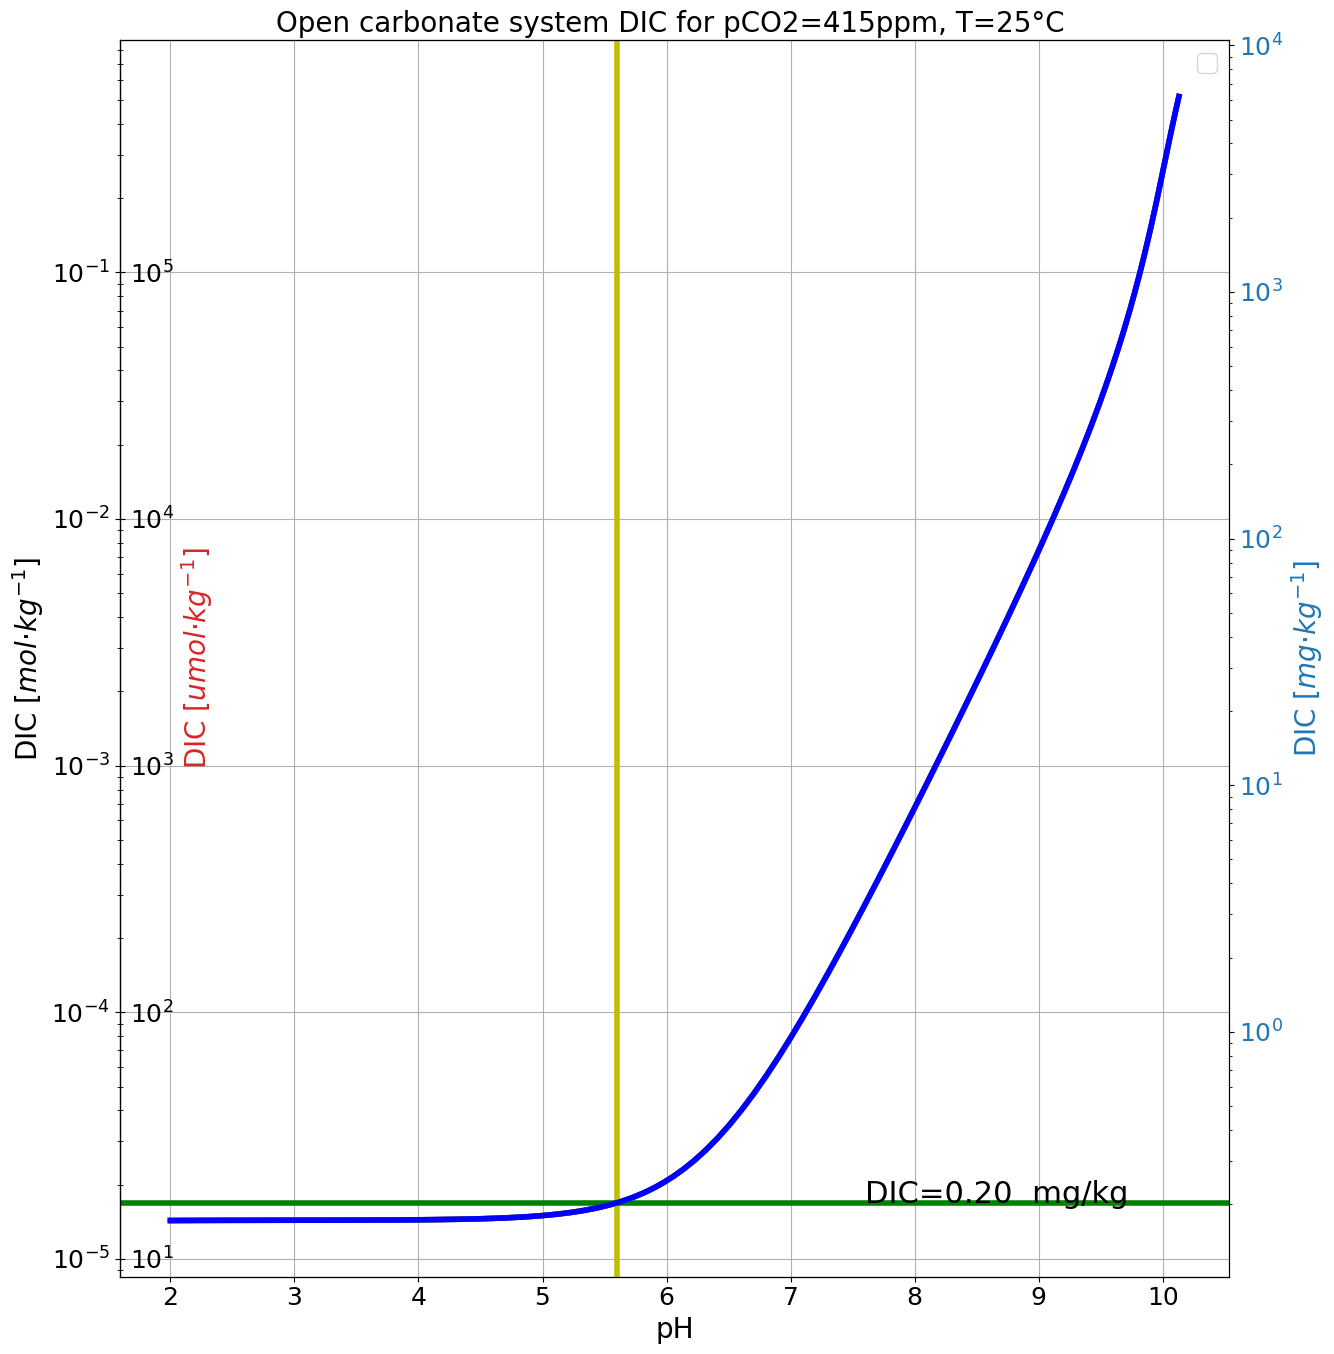

In [47]:
fig = plt.figure(figsize=[14,14])
plt.plot(pH_value,DIC,label='DIC',color='red')

#get the density of the solution


# line for TA=0
plt.axvline(x=zero_pH, color = 'y', label = 'pH of pure water \n in eq with atmos')

plt.xlabel("pH")
plt.ylabel("DIC [$mol·kg^{−1}$]")
plt.title("Open carbonate system DIC for pCO2={}ppm, T={}°C ".format(p,T))


plt.axhline(y=zero_DIC, color = 'g', label = 'DIC of pure water \n in eq with atmos')



ax1 = plt.gca()
ax1.grid(True)

ax1.set_yscale('log')

#molar mass Carbon
M=12.011


# for the second scale
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('DIC [$ mg · kg^{-1}$]', color=color)  # we already handled the x-label with ax1

ax2.plot(pH_value, [x*M*1000 for x in DIC], color=color)
ax2.tick_params(axis='y', labelcolor=color)


ax2.text(x=zero_pH+2, y=zero_DIC*M*1000, s='DIC={:.2f}  mg/kg '.format(zero_DIC*M*1000))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax2.set_yscale('log')

# for the third scale
color = 'tab:red'

ax3 = ax1.twinx()
ax3.set_ylabel('DIC [$ umol · kg^{-1}$]', color=color)

ax3.plot(pH_value, [x*1000*1000 for x in DIC], color='blue')

ax3.spines['right'].set_position(('axes', 0.0))

ax3.set_yscale('log')

ax2.legend()



#plt.xlim([3,10])
#ax.set_ylim([1e-6,1e0])

#add extra axis



## DIC(TA) relationship plot

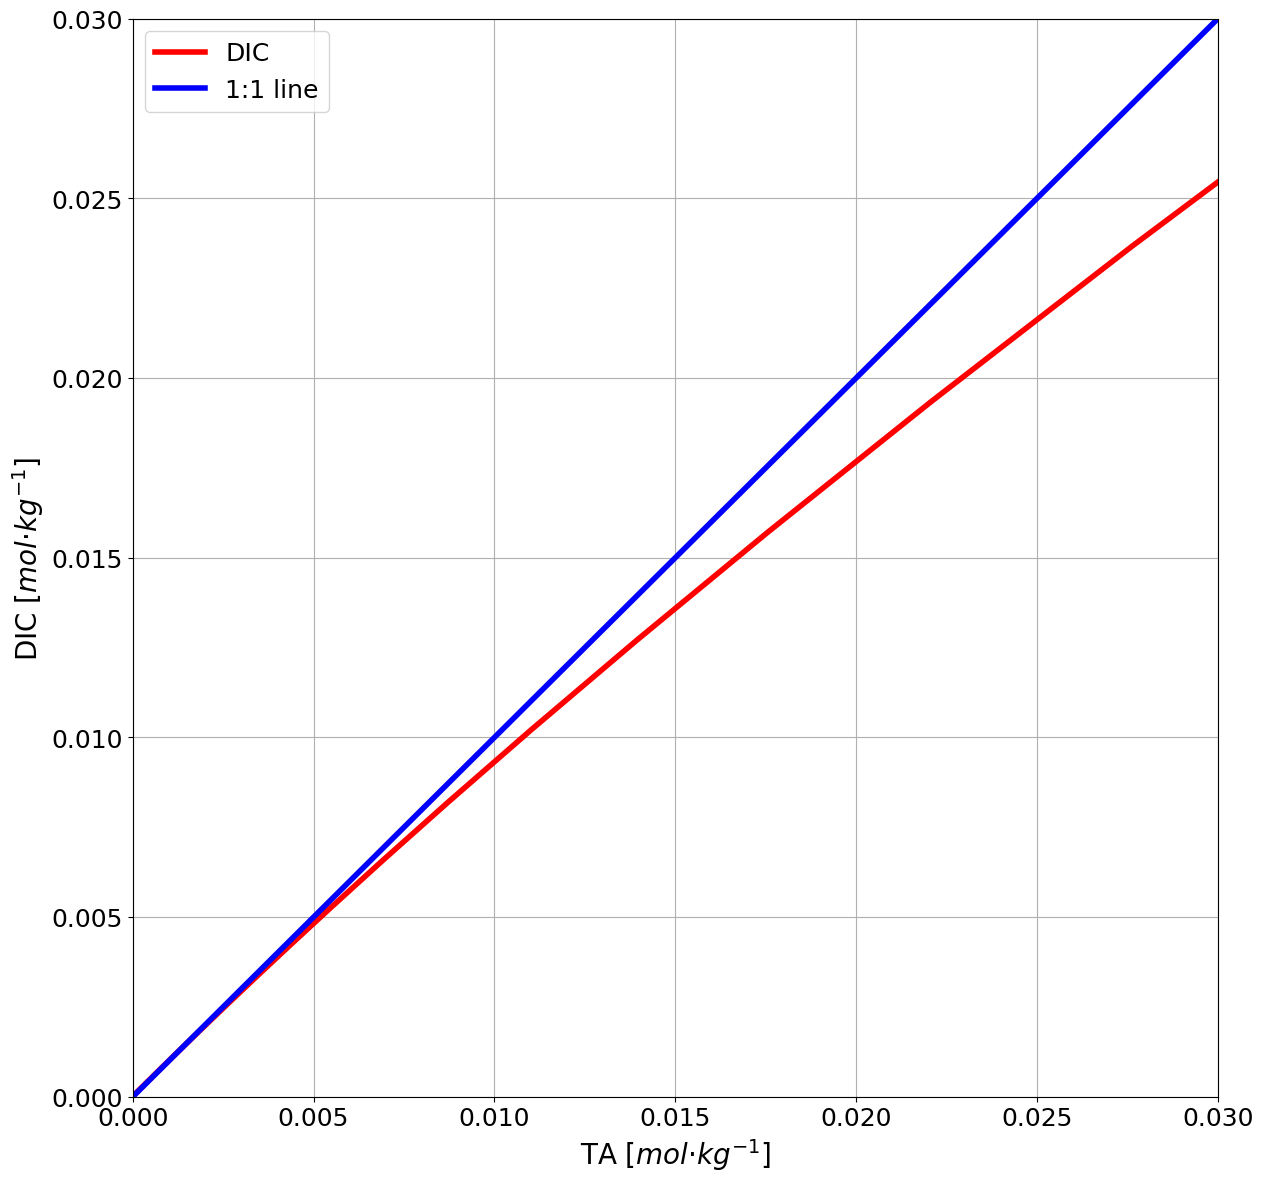

In [48]:
fig = plt.figure(figsize=[14,14])
plt.plot(TA,DIC,label='DIC',color='red')

#define range to display [mol/kg]
lim=[0,0.03]

plt.plot(lim,lim,label='1:1 line',color='blue')

plt.xlabel("TA [$mol·kg^{−1}$]")
plt.ylabel("DIC [$mol·kg^{−1}$]")

plt.xlim(lim)
plt.ylim(lim)

ax1 = plt.gca()
ax1.grid(True)
plt.legend()

#ax1.set_yscale('log')

In [49]:
sol.species

{'CH4': 0.0,
 'CO2': 7.614879199380983e-06,
 'CO3-2': 0.3809770035670511,
 'H+': 1.0712283827825872e-10,
 'H2': 2.7812966730360986e-40,
 'H2O': 57.63701232330769,
 'HCO3-': 0.1351769086074503,
 'Na+': 2.644124819564544,
 'NaCO3-': 1.746737412435062,
 'NaHCO3': 0.056685642371952984,
 'NaOH': 1.5992472127728495e-14,
 'O2': 6.805466646643358e-15,
 'OH-': 0.0002564900126361598}

If you want to see everything in a browser window use this: 

In [50]:
from dash import Dash, dash_table


# test

lol=pd.DataFrame.from_dict(sol.species, orient='index',columns=['concentration'])

# make extra column for the names


lol=lol.rename_axis(['species']).reset_index()



# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html


app = Dash(__name__)

cols=[{'name': 'species', 'id': 'species'},
 {'name': 'concentration', 'id': 'concentration','type':'numeric','format':dash_table.Format.Format(precision=4, scheme=dash_table.Format.Scheme.exponent)}]


app.layout = dash_table.DataTable(lol.to_dict('records'),columns = cols)


if __name__ == '__main__':
    app.run_server(debug=True)
    
    

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


SystemExit: 1

C:\Users\u301072\AppData\Local\conda\conda\envs\spyder\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
